In [1]:
import gensim
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance, euclidean_distance
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [2]:
# sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
# sentence_president = 'The president greets the press in Chicago'.lower().split()

# model.wmdistance(sentence_obama, sentence_president)

In [5]:
import numpy as np
corpus = [
    "Can you be more specific with your question?",
    "Are you able to eliminate ambiguity from your question?",
    "Could you be more specific?",
    "Can you explain yourself more clearly?",
    "Please be more specific",
    "Will you restate your question more clearly?",
    "Quick brown fox jumped over the lazy dog",
    "The dog lay on the floor and the fox jumped over it",
    "Unlike the dog, the fox was quick and brown and was able to jump over the dog",
    "The dog was lazy and could not reach the fox which jumped over it",
    "The dog could not match the fox's speed who easily jumped over it and disappeared"
]

data = []
for sentence in corpus:
    sentence = sentence.lower().split()
    res = 0
    n = 0
    for word in sentence:
        try:
            res+=model[word]
            n+=1
        except:
            pass
    res/=n
    #print(n)
    data.append(res)
    
data = np.array(data)
data

array([[ 0.04987444, -0.06780134,  0.04781669, ..., -0.10934884,
        -0.03798131, -0.00711496],
       [ 0.09814453,  0.03697981,  0.07805525, ..., -0.0411832 ,
        -0.00385393,  0.02963693],
       [ 0.04077148, -0.07476807,  0.06738281, ..., -0.15255737,
         0.02854156, -0.01379395],
       ..., 
       [ 0.08391395,  0.04641958, -0.01053561, ...,  0.02064397,
        -0.01310847,  0.01273287],
       [ 0.0556265 ,  0.03016178, -0.00081693, ..., -0.00397433,
        -0.01363197, -0.02832031],
       [ 0.06526066,  0.05781541,  0.02741887, ..., -0.04923307,
        -0.0231112 , -0.06109384]], dtype=float32)

In [6]:
NUM_CLUSTERS = 2

#def mydist(x, y):
#    return model.wmdistance(x, y)

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=cosine_distance, repeats=10)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)

assigned_clusters

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [69]:
import re
for j in range(NUM_CLUSTERS):
    cluster = [corpus[i] for i in range(len(corpus)) if assigned_clusters[i]==j]

    text = []
    for i in range(len(cluster)):
        sentense = str(cluster[i]).lower().split(" ")
        for word in sentense:
            text.append(re.sub(r'[^\w\s]','',str(word)))

    f = open("cluster_"+str(j)+".txt", 'w')
    for item in text:
        f.write("%s\n" % item)
    f.close()

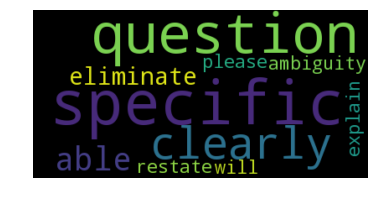

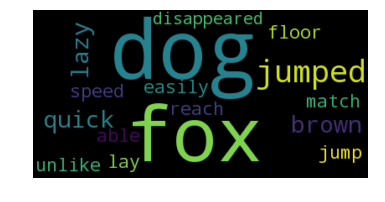

In [70]:
for j in range(NUM_CLUSTERS):
    text = open("cluster_"+str(j)+".txt").read()
    wordcloud = WordCloud().generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()